In [1]:
from os.path import join
import pyelsa as elsa
import aomip
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mig
import utils
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import signal
# from GradientDescent import gradient_descent
# import sympy
from skimage.transform import radon, rescale
import preprocessing
import time

pyelsa not build with CUDA projector support


In [2]:
data_path = '20211124_seashell'
projs_name = '20211124_seashell_{:04}.tif'
projs_rows = 2368
projs_cols = 2240
num_projections = 721
# create the numpy array which will receive projection data from tiff files
projs = np.zeros((num_projections, projs_rows, projs_cols), dtype=np.float32)
# load projection data
for i in range(1,num_projections):
    projs[i] = plt.imread(join(data_path, projs_name.format(i)))


In [3]:
new_projs_rows = (projs[0].shape[0] // 8)
new_projs_cols = (projs[0].shape[1] // 8)
bin_factor = 8
binned_projections = preprocessing.containerised_projections(num_projections,new_projs_rows,new_projs_cols,projs,4,bin_factor)


(296, 280)


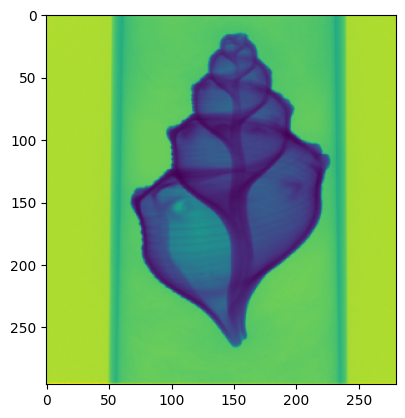

In [4]:
print(binned_projections[5].shape)
plt.imshow(binned_projections[5])

# Homework 1: Preprocessing again

In [4]:
slice_idx_50 = 50
slice_idx_100 = 150
slice_idx_200 = 200
# slice_idx_400 = 400
# slice_idx_600 = 600

sliced_sinogram_50 = np.empty((num_projections, new_projs_cols), dtype=np.float32)
sliced_sinogram_100 = np.empty((num_projections, new_projs_cols), dtype=np.float32)
sliced_sinogram_200 = np.empty((num_projections, new_projs_cols), dtype=np.float32)
# sliced_sinogram_400 = np.empty((num_projections, new_projs_cols), dtype=np.float32)
# sliced_sinogram_600 = np.empty((num_projections, new_projs_cols), dtype=np.float32)

for i in range(num_projections):
    proj=binned_projections[i]
    row_50 = proj[slice_idx_50, :]
    sliced_sinogram_50[i, :] = row_50
    row_100 = proj[slice_idx_100, :]
    sliced_sinogram_100[i, :] = row_100
    row_200 = proj[slice_idx_200, :]
    sliced_sinogram_200[i, :] = row_200
#     row_400 = proj[slice_idx_400, :]
#     sliced_sinogram_400[i, :] = row_400
#     row_600 = proj[slice_idx_600, :]
#     sliced_sinogram_600[i, :] = row_600

utils.save_array_as_image(sliced_sinogram_50,'sliced_sinogram_50.png','Img')
utils.save_array_as_image(sliced_sinogram_100,'sliced_sinogram_100.png','Img')
utils.save_array_as_image(sliced_sinogram_200,'sliced_sinogram_200.png','Img')
# utils.save_array_as_image(sliced_sinogram_400,'sliced_sinogram_400.png','Img')
# utils.save_array_as_image(sliced_sinogram_600,'sliced_sinogram_600.png','Img')

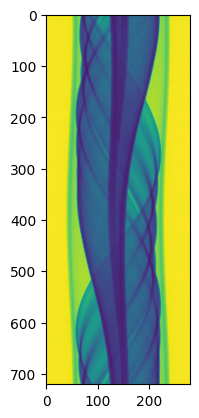

In [6]:
plt.imshow(sliced_sinogram_100)

# Homework 3: Solving CT Problems

(i) Least Squares


In [5]:
def f(A,b,x):
    return 0.5* np.linalg.norm(A.dot(x) - b)**2

def df(A,b,x):
    return (A.T).dot(A.dot(x))- (A.T).dot(b)
    #return A.T.dot(A.dot(x)-b)
    
def gradientDescent(function,A,b, x0, iterations, alpha=1e-5):
    x = x0
    eps=1e-6
    stopIdx=0
    history = np.zeros((x0.size, iterations+1))
    history[:, 0] = x0
    
    value0 = function(A,b,x0)
    values = np.zeros(iterations+1)
    values[0] = value0
    
    for i in range(iterations):
        d = df(A,b,x) #A.T.dot(A.dot(x)-b)
        #alpha = 1e-7 #(d.T).dot(d) / (d.T).dot(A).dot(d)
        x = x - alpha*d
        history[:,i+1] = x
        values[i] = function(A,b,x)
        stopIdx=i
        if np.linalg.norm(d) < eps:
            stopIdx=i
            break
            
    return history, values, stopIdx

In [6]:
size = (new_projs_rows,new_projs_cols)
A = aomip.XrayOperator(size, [721], np.linspace(0, 360, new_projs_cols), size[0]*1, size[0]*0.5)
b = sliced_sinogram_100.flatten()
print("A has size = ", A.shape, ", and b has size = ", b.size)
initial_x0 = np.array(np.zeros(new_projs_rows*new_projs_cols))-0.1

H = np.linspace(-1, 1, sliced_sinogram_100.shape[0])

ram_lak = np.abs(H)
shepp_logan = np.abs(H) * np.sinc(H / 2)
cosine = np.abs(H) * np.cos(H * np.pi / 2)

h = np.tile(ram_lak, (280, 1)).T
fftsino = np.fft.fft(sliced_sinogram_100, axis=0)
projection = np.fft.fftshift(fftsino, axes=1) * np.fft.fftshift(h, axes=0)
fsino = np.real(np.fft.ifft(np.fft.ifftshift(projection, axes=1), axis=0))


[2023-05-08 16:04:22.403] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 280 poses in an 360 degree arc
A has size =  (201880, 82880) , and b has size =  201880


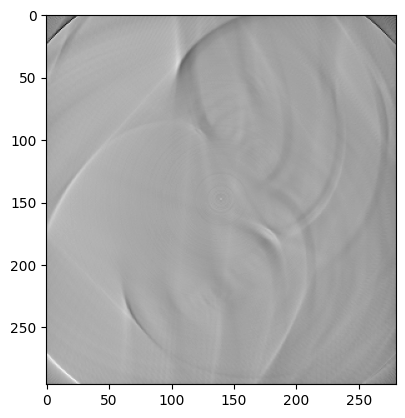

In [9]:
iteration = 5
alpha=1e-3
hist, minv, stopIdx = gradientDescent(f,A,fsino.flatten(),initial_x0,iteration,alpha)
xreconstructed = (hist[:,stopIdx]).reshape(size)
plt.imshow(xreconstructed, cmap='gray')
utils.save_array_as_image(xreconstructed,'reconstructed_gd_sino150.png','Img')

NameError: name 'xreconstructed' is not defined

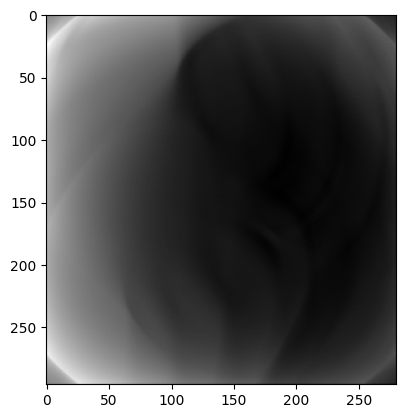

In [8]:
iteration = 5
alpha=1e-3
hist, minv, stopIdx = gradientDescent(f,A,b,initial_x0,iteration,alpha)
xreconstructednofilter = (hist[:,stopIdx]).reshape(size)
plt.imshow(xreconstructednofilter, cmap='gray')


In [10]:
#utils.save_array_as_image(xreconstructednofilter,'reconstructed_gd_unfiltered_sino150.png','Img')

(ii) L2-Norm squared

In [11]:
def f_tikohonov(A,x,b,beta):
    return 0.5* np.linalg.norm(A.dot(x) - b)**2 + 0.5*beta*x.dot(x)

def dff_tikohonov(A,x,b,beta):
    return A.T.dot(A.dot(x)-b) + beta*x

def gradientDescentTikhonov(function,A,b,beta,x0, iterations, alpha=1e-5):
    x = x0
    eps=1e-6
    stopIdx=0
    history = np.zeros((x0.size, iterations+1))
    history[:, 0] = x0
    
    value0 = function(A,x0,b,beta)
    values = np.zeros(iterations+1)
    values[0] = value0
    
    for i in range(iterations):
        d = dff_tikohonov(A,x,b,beta) #A.T.dot(A.dot(x)-b)
        alpha = 1e-7 #(d.T).dot(d) / (d.T).dot(A).dot(d)
        x = x - alpha*d
        history[:,i+1] = x
        values[i] = function(A,x,b,beta)
        stopIdx=i
        if np.linalg.norm(d) < eps:
            stopIdx=i
            break
            
    return history, values, stopIdx

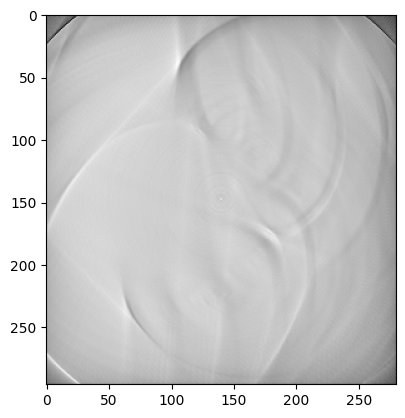

In [12]:
iteration = 5
beta=2
hist, minv, stopIdx = gradientDescentTikhonov(f_tikohonov,A,fsino.flatten(),beta,initial_x0,iteration, 1e-3)
xreconstructedTikonov = (hist[:,stopIdx]).reshape(size)
plt.imshow(xreconstructedTikonov, cmap='gray')
utils.save_array_as_image(xreconstructedTikonov,'reconstructed_tiknonov_sino150.png','Img')

iii) Huber Functional


In [13]:
def huber_loss(A,b,x, delta):
    abs_x = np.abs(x)
    loss = np.where(abs_x <= delta, 0.5 * x ** 2, delta * (abs_x - 0.5 * delta))
    return 0.5* np.linalg.norm(A.dot(x) - b)**2 + np.sum(loss)

def huber_loss_gradient(x, delta):
    """
    Computes the gradient of the Huber loss of x with parameter delta.
    """
    abs_x = np.abs(x)
    gradient = np.where(abs_x <= delta, x, delta * np.sign(x))
    return gradient

def gradientDescentHuber(function,A,b,delta,x0, iterations, alpha=1e-3):
    x = x0
    eps=1e-6
    stopIdx=0
    history = np.zeros((x0.size, iterations+1))
    history[:, 0] = x0
    
    value0 = function(A,b,x0,delta)
    values = np.zeros(iterations+1)
    values[0] = value0
    
    for i in range(iterations):
        d = df(A,b,x) + huber_loss_gradient(x, delta)
        x = x - alpha*d
        history[:,i+1] = x
        values[i] = function(A,b,x0,delta)
        stopIdx=i
        if np.linalg.norm(d) < eps:
            stopIdx=i
            break
        
    return history, values, stopIdx

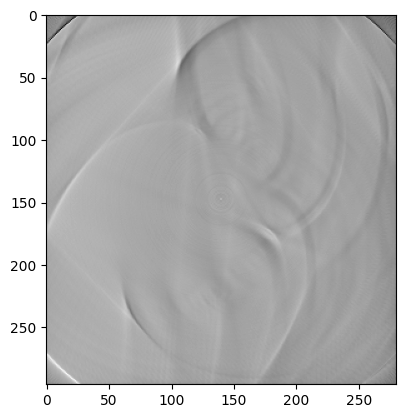

In [14]:
iteration = 5
delta=2
hist, minv, stopIdx = gradientDescentHuber(huber_loss,A,fsino.flatten(),delta,initial_x0,iteration,1e-3)
xreconstructedHuber = (hist[:,stopIdx]).reshape(size)
plt.imshow(xreconstructedHuber, cmap='gray')
utils.save_array_as_image(xreconstructedHuber,'reconstructed_Huber_sino150.png','Img')

iv) Fair potential

In [18]:
def fair(A,b,x,lambd):
    lrTerm = 0.5* np.linalg.norm(A.dot(x) - b)**2
    absTerm = np.abs(x/lambd)
    reg = (lambd**2) * np.sum(absTerm - np.log(1 + absTerm))
    return lrTerm + reg

def fair_grad(x, lambd):
    xTerm = x/lambd
    return x / (1 + xTerm)

def gradientDescentFair(function,A,b,lambd,x0, iterations, alpha=1e-3):
    x = x0
    eps=1e-6
    stopIdx=0
    history = np.zeros((x0.size, iterations+1))
    history[:, 0] = x0
    
    value0 = function(A,b,x0,delta)
    values = np.zeros(iterations+1)
    values[0] = value0
    
    for i in range(iterations):
        d = df(A,b,x) + fair_grad(x, lambd)
        x = x - alpha*d
        history[:,i+1] = x
        values[i] = function(A,b,x0,delta)
        stopIdx=i
        if np.linalg.norm(d) < eps:
            stopIdx=i
            break
        
    return history, values, stopIdx

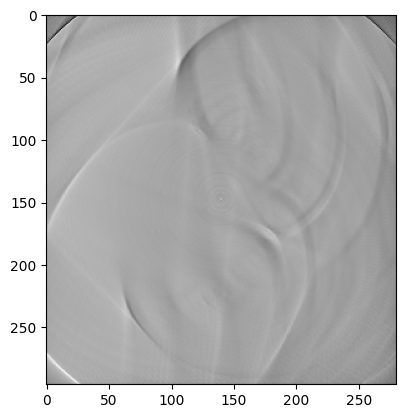

In [19]:
iteration = 5
delta=2
hist, minv, stopIdx = gradientDescentFair(fair,A,fsino.flatten(),delta,initial_x0,iteration,1e-3)
xreconstructedFair = (hist[:,stopIdx]).reshape(size)
plt.imshow(xreconstructedFair, cmap='gray')
utils.save_array_as_image(xreconstructedTikonov,'reconstructed_Fair_sino150.png','Img')

# Homework 4: Finite Differences

Only works in GPU (note), because L (finite difference operator) multiply by its transpose is too computationally intensive for CPU

In [1]:
def finite_diff_op_1d(n):
    """
    Returns the finite difference operator for a 1D signal with n samples.
    """
    D = np.zeros((n-1,n))
    for i in range(n-1):
        D[i,i] = -1
        D[i,i+1] = 1
    return D

def generate_pattern_matrix(n):
    """
        Generate L transpose multiply L
    """
    diagonal = np.ones(n) * 2
    sub_diagonal = np.ones(n - 1) * -1
    A = np.diag(diagonal) + np.diag(sub_diagonal, k=-1) + np.diag(sub_diagonal, k=1)
    A[0, 1] = -1
    A[-1, -2] = -1
    A[0, 0] = 1
    A[-1, -1] = 1
    return A

def f_finDiff(A,x,b,L,beta=1):
    return 0.5* np.linalg.norm(A.dot(x) - b)**2 + 0.5*beta*np.linalg.norm(L.dot(x))**2

def dff_finDiff(A,x,b,L,beta):
    return A.T.dot(A.dot(x)-b) + beta*(generate_pattern_matrix(x.size)).dot(x)

def gradientDescentFinDiff(A,b,beta,L,x0, iterations, alpha=1e-5):
    x = x0
    eps=1e-6
    stopIdx=0
    history = np.zeros((x0.size, iterations+1))
    history[:, 0] = x0
    
    for i in range(iterations):
        d = dff_finDiff(A,x,b,L,beta) #A.T.dot(A.dot(x)-b)
        x = x - alpha*d
        history[:,i+1] = x
        stopIdx=i
        if np.linalg.norm(d) < eps:
            stopIdx=i
            break
            
    return history, stopIdx

def huber_loss_fd(A,b,x,L, delta,beta=1):
    abs_x = np.abs(x)
    loss = np.where(abs_x <= delta, 0.5 * x ** 2, delta * (abs_x - 0.5 * delta))
    return f_finDiff(A,x,b,L,beta) + np.sum(loss)

def gradientDescentHuberFd(A,b,delta,L,x0, iterations, alpha=1e-3):
    x = x0
    eps=1e-6
    stopIdx=0
    history = np.zeros((x0.size, iterations+1))
    history[:, 0] = x0
    
    for i in range(iterations):
        d = dff_finDiff(A,x,b,L,1)  + huber_loss_gradient(x, delta)
        x = x - alpha*d
        history[:,i+1] = x
        stopIdx=i
        if np.linalg.norm(d) < eps:
            stopIdx=i
            break
        
    return history, stopIdx

def gradientDescentFairFd(A,b,lambd,L,x0,iterations, alpha=1e-3):
    x = x0
    eps=1e-6
    stopIdx=0
    history = np.zeros((x0.size, iterations+1))
    history[:, 0] = x0

    for i in range(iterations):
        d = dff_finDiff(A,x,b,L,1) + fair_grad(x, lambd)
        x = x - alpha*d
        history[:,i+1] = x
        stopIdx=i
        if np.linalg.norm(d) < eps:
            stopIdx=i
            break
        
    return history, stopIdx



In [ ]:
L=finite_diff_op_1d(initial_x0.size)
iteration = 3
beta=5
hist, stopIdx = gradientDescentFinDiff(A,fsino.flatten(),beta,L,initial_x0,iteration,1e-3)
xreconstructedFairFd = (hist[:,stopIdx]).reshape(size)
plt.imshow(xreconstructedFair, cmap='gray')
utils.save_array_as_image(xreconstructedTikonov,'reconstructed_Fair_sino150.png','Img')

In [ ]:
opt1=finite_diff_op_1d(10)
ltl = generate_pattern_matrix(80000)
print(ltl.shape)

In [ ]:
A2=np.ones((4, 4))
b2=np.ones(4)
L2=finite_diff_op_1d(4)
iteration2 = 10
initial_x02=np.random.random(4)
beta2=2
hist2, stopIdx2 = gradientDescentFinDiff(A2,b2,beta2,L2,initial_x02,iteration,21e-3)
print(hist2)
hist2, stopIdx2 = gradientDescentHuberFd(A2,b2,1,L2,initial_x02,iteration2,1e-3)
print(hist)
hist2, stopIdx2 = gradientDescentFair(A2,b2,1,L2,initial_x02,iteration2,1e-3)
print(hist)

# Homework 5 Iterative algorithm vs FBP


In [39]:
filtered_recon=A.applyAdjoint(fsino)
utils.save_array_as_image(filtered_recon,'reconstructed_fbp_sino150.png','Img')

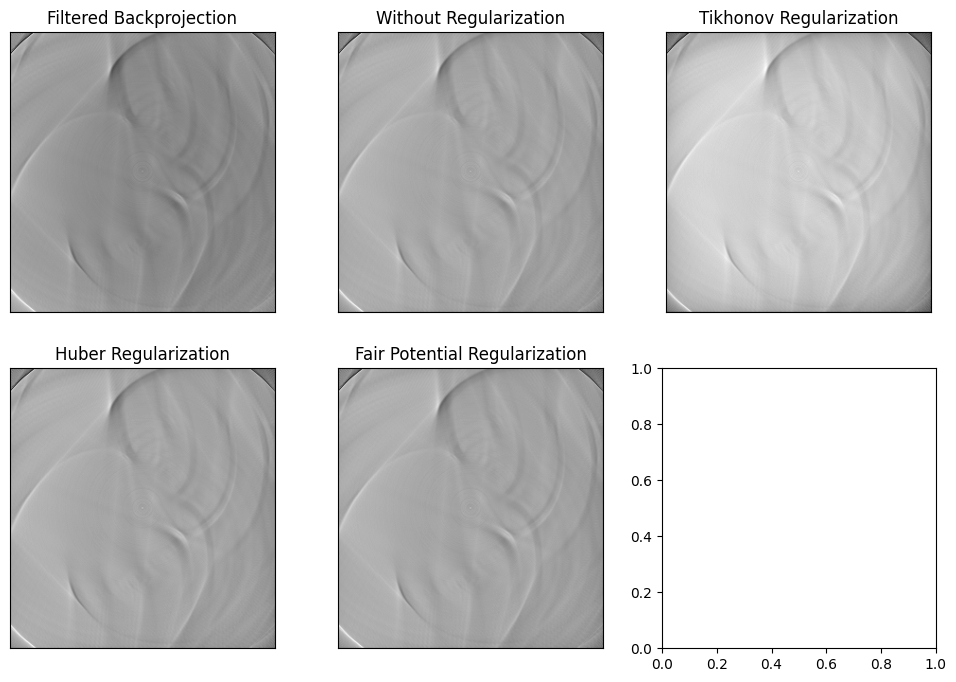

error between fbp and reconstruction without regularization:  2560.7110759391308
error between fbp and reconstruction with Tikhonov regularization:  2591.3540618943857
error between fbp and reconstruction with Huber Functional regularization:  2560.70016373615
error between fbp and reconstruction with Fair Potential regularization:  2560.699798583447


In [40]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].imshow(filtered_recon, cmap="gray")
ax[0, 0].set_title("Filtered Backprojection")
ax[0, 0].get_xaxis().set_visible(False)
ax[0, 0].get_yaxis().set_visible(False)

ax[0, 1].imshow(xreconstructed, cmap="gray")
ax[0, 1].set_title("Without Regularization")
ax[0, 1].get_xaxis().set_visible(False)
ax[0, 1].get_yaxis().set_visible(False)

ax[0, 2].imshow(xreconstructedTikonov, cmap="gray")
ax[0, 2].set_title("Tikhonov Regularization")
ax[0, 2].get_xaxis().set_visible(False)
ax[0, 2].get_yaxis().set_visible(False)

ax[1, 0].imshow(xreconstructedHuber, cmap="gray")
ax[1, 0].set_title("Huber Regularization")
ax[1, 0].get_xaxis().set_visible(False)
ax[1, 0].get_yaxis().set_visible(False)

ax[1, 1].imshow(xreconstructedFair, cmap="gray")
ax[1, 1].set_title("Fair Potential Regularization")
ax[1, 1].get_xaxis().set_visible(False)
ax[1, 1].get_yaxis().set_visible(False)

plt.show()

print('error between fbp and reconstruction without regularization: ',np.linalg.norm(filtered_recon-xreconstructed))
print('error between fbp and reconstruction with Tikhonov regularization: ',np.linalg.norm(filtered_recon-xreconstructedTikonov))
print('error between fbp and reconstruction with Huber Functional regularization: ',np.linalg.norm(filtered_recon-xreconstructedHuber))
print('error between fbp and reconstruction with Fair Potential regularization: ',np.linalg.norm(filtered_recon-xreconstructedFair))



Add noise

In [45]:
noise = max(fsino.flatten()) * 0.01 * np.random.randn(fsino.flatten().size)
bNoisy = fsino.flatten() + noise

# use fbp to reconstruct
start_time1 = time.time()
fbp_noisy=A.applyAdjoint(bNoisy)
utils.save_array_as_image(fbp_noisy,'reconstructed_fbp_noisy.png','Img')
end_time1 = time.time()
elapsed_time1 = end_time1 - start_time1

# Using gd without regularization to reconstruct
start_time2 = time.time()
hist, minv, stopIdx = gradientDescent(f,A,bNoisy,initial_x0,iteration,alpha)
xreconstructedNoisy = (hist[:,stopIdx]).reshape(size)
utils.save_array_as_image(xreconstructedNoisy,'reconstructed_gd_noisy.png','Img')
end_time2 = time.time()
elapsed_time2 = end_time2 - start_time2

# Using gd with Tikhonov regularization to reconstruct
start_time3 = time.time()
hist, minv, stopIdx = gradientDescentTikhonov(f_tikohonov,A,bNoisy,beta,initial_x0,iteration, alpha)
xreconstructedTikonovNoisy = (hist[:,stopIdx]).reshape(size)
utils.save_array_as_image(xreconstructedTikonovNoisy,'reconstructed_tiknonov_noisy.png','Img')
end_time3 = time.time()
elapsed_time3 = end_time3 - start_time3

# Using gd with Huber as regularization to reconstruct
start_time4 = time.time()
hist, minv, stopIdx = gradientDescentHuber(huber_loss,A,bNoisy,delta,initial_x0,iteration,1e-3)
xreconstructedHuberNoisy = (hist[:,stopIdx]).reshape(size)
utils.save_array_as_image(xreconstructedHuberNoisy,'reconstructed_Huber_noisy.png','Img')
end_time4 = time.time()
elapsed_time4 = end_time4 - start_time4

# Using gd with Fair Potential as regularization to reconstruct
start_time5 = time.time()
hist, minv, stopIdx = gradientDescentFair(fair,A,bNoisy,delta,initial_x0,iteration,1e-3)
xreconstructedFairNoisy = (hist[:,stopIdx]).reshape(size)
utils.save_array_as_image(xreconstructedFairNoisy,'reconstructed_Fair_noisy.png','Img')
end_time5 = time.time()
elapsed_time5 = end_time5 - start_time5

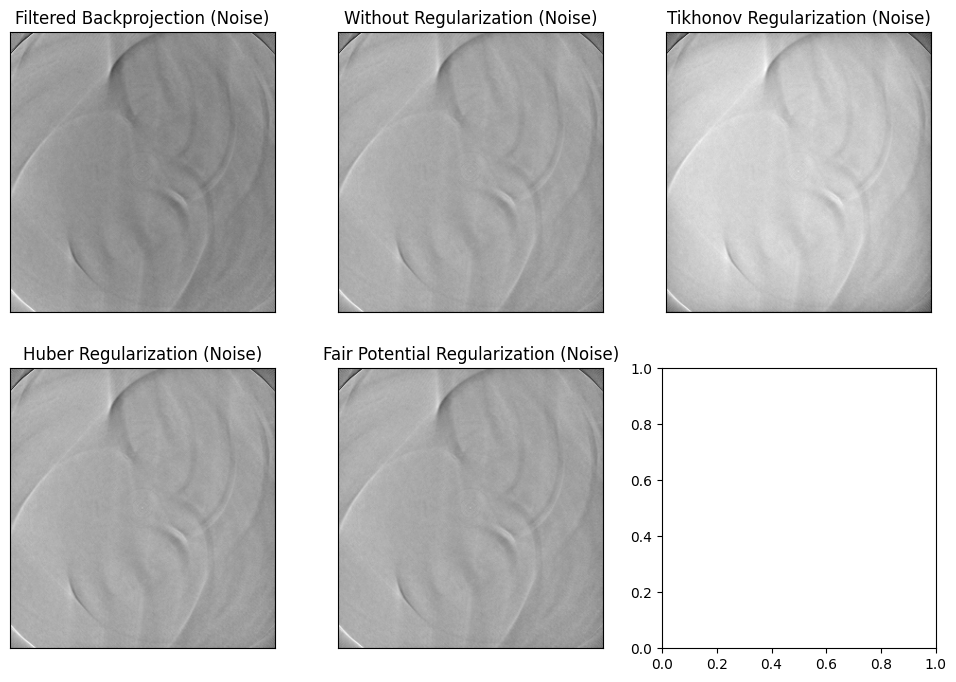

error between fbp and reconstruction without regularization:  2548.8305657898545
error between fbp and reconstruction with Tikhonov regularization:  2579.4322549440826
error between fbp and reconstruction with Huber Functional regularization:  2548.8196578739226
error between fbp and reconstruction with Fair Potential regularization:  2548.8192930941996
time fbp:  2.315293073654175
time without regularization:  48.35488414764404
time with Tikhonov regularization:  37.62824606895447
time with Huber Functional regularization:  48.92222285270691
time with Fair Potential regularization:  49.4227180480957


In [46]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].imshow(fbp_noisy, cmap="gray")
ax[0, 0].set_title("Filtered Backprojection (Noise)")
ax[0, 0].get_xaxis().set_visible(False)
ax[0, 0].get_yaxis().set_visible(False)

ax[0, 1].imshow(xreconstructedNoisy, cmap="gray")
ax[0, 1].set_title("Without Regularization (Noise)")
ax[0, 1].get_xaxis().set_visible(False)
ax[0, 1].get_yaxis().set_visible(False)

ax[0, 2].imshow(xreconstructedTikonovNoisy, cmap="gray")
ax[0, 2].set_title("Tikhonov Regularization (Noise)")
ax[0, 2].get_xaxis().set_visible(False)
ax[0, 2].get_yaxis().set_visible(False)

ax[1, 0].imshow(xreconstructedHuberNoisy, cmap="gray")
ax[1, 0].set_title("Huber Regularization (Noise)")
ax[1, 0].get_xaxis().set_visible(False)
ax[1, 0].get_yaxis().set_visible(False)

ax[1, 1].imshow(xreconstructedFairNoisy, cmap="gray")
ax[1, 1].set_title("Fair Potential Regularization (Noise)")
ax[1, 1].get_xaxis().set_visible(False)
ax[1, 1].get_yaxis().set_visible(False)

plt.show()

print('error between fbp and reconstruction without regularization: ',np.linalg.norm(fbp_noisy-xreconstructedNoisy))
print('error between fbp and reconstruction with Tikhonov regularization: ',np.linalg.norm(fbp_noisy-xreconstructedTikonovNoisy))
print('error between fbp and reconstruction with Huber Functional regularization: ',np.linalg.norm(fbp_noisy-xreconstructedHuberNoisy))
print('error between fbp and reconstruction with Fair Potential regularization: ',np.linalg.norm(fbp_noisy-xreconstructedFairNoisy))

print('time fbp: ',elapsed_time1)
print('time without regularization: ',elapsed_time2)
print('time with Tikhonov regularization: ',elapsed_time3)
print('time with Huber Functional regularization: ',elapsed_time4)
print('time with Fair Potential regularization: ',elapsed_time5)

